In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from Models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [2]:
from tslearn.clustering import TimeSeriesKMeans

/home/ambekar/anaconda3/envs/safeml/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Load and Prepare data to input to LSTM model

In [3]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [21]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [22]:
def modify_test_data(test_set, mean, variance):
    
    noise = np.random.normal(mean, variance, len(test_set))
    modified_test_Set = test_set + noise

    return modified_test_Set

In [23]:
train_set, test_set = splitData(data['Close'].values)
# modified_test_set = modify_test_data(test_set, 0, 0)

In [64]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [63]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [65]:
train_norm, test_norm = normalize_data(train_set, test_set)
train_norm, test_norm = normalize_data(train_set, test_set)

In [66]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [67]:
x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

In [68]:
x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

In [69]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


In [49]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,                          
                          metric="dtw",                          
                          max_iter_barycenter=10,
                          random_state=41)
y_pred = dba_km.fit_predict(x_train)

DBA k-means


In [50]:
sz = x_train.shape[1]

(0.0, 20.0)

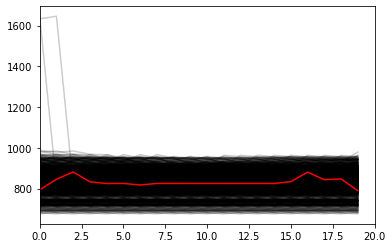

In [51]:
for xx in x_train[y_pred == 0]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[0].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

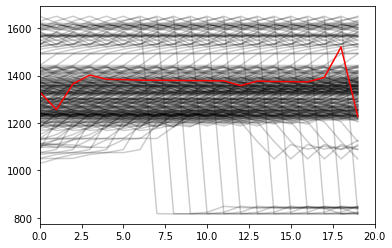

In [52]:
for xx in x_train[y_pred == 1]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[1].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

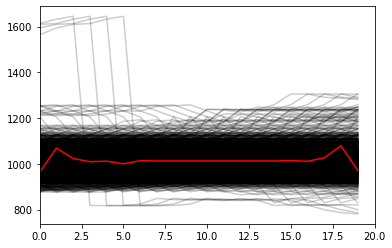

In [53]:
for xx in x_train[y_pred == 2]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.xlim(0, sz)

In [57]:
cluster2 = dba_km.cluster_centers_[2]

r1 = np.mean(cluster2)
print("\nMean: ", r1)
  
r2 = np.std(cluster2)
print("\nstd: ", r2)
  
r3 = np.var(cluster2)
print("\nvariance: ", r3)


Mean:  1014.5690912954694

std:  24.55455225024012

variance:  602.9260362097722


In [54]:
for xx in x_train[y_pred == 3]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.xlim(0, sz)

IndexError: index 3 is out of bounds for axis 0 with size 3

(0.0, 20.0)

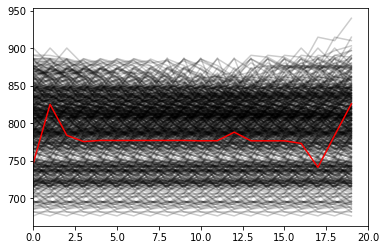

In [48]:
for xx in x_train[y_pred == 4]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[4].ravel(), "r-")
plt.xlim(0, sz)

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [70]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [71]:
# make predictions
y_test_pred = model(x_test[:10])

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# y_test_pred = y_test_pred.detach().numpy()
# y_test = y_test_lstm.detach().numpy()

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:10,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:10], y_test_pred)
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {r2_score(y_test[:10], y_test_pred)}')

Test Score: 0.01 MAPE
R-squared value is -0.8900026816868833


In [74]:
y_test_pred, y_test[:10]

(array([[1319.8129],
        [1314.044 ],
        [1319.8374],
        [1327.3733],
        [1346.5345],
        [1357.0804],
        [1346.7465],
        [1326.988 ],
        [1315.9087],
        [1318.6744]], dtype=float32),
 array([[1313.05  ],
        [1329.75  ],
        [1330.15  ],
        [1360.2001],
        [1351.6499],
        [1327.35  ],
        [1314.9   ],
        [1319.15  ],
        [1329.1499],
        [1332.15  ]], dtype=float32))

In [75]:
preds = y_test_pred

r1 = np.mean(preds)
print("\nMean: ", r1)
  
r2 = np.std(preds)
print("\nstd: ", r2)
  
r3 = np.var(preds)
print("\nvariance: ", r3)


Mean:  1329.3

std:  14.445561

variance:  208.67424
